---
# 0. 라이브러리
----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from torchvision import transforms, datasets

from PIL import Image
from pprint import pprint
import easydict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import librosa
from collections import Counter

In [3]:
cd /content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/

/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data


---
# 1. Data
----

In [4]:
class Config():
  train = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/train.csv'
  test = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/test.csv'
  sub = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sample_submission.csv'
  epoch = 100
  lr = 1e-5
  sr = 16000
  batch_size = 64
  weight_decay_ae = 5e-8
  latent_dim = 2
  pretrain = True
  weight_decay = 5e-8
  lr_milestones = [25, 50, 75]

config = Config()

In [5]:
train = pd.read_csv(config.train)
test = pd.read_csv(config.test)
train

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


---
# 2. Preprocessing
---

In [6]:
# 각 오디오 파일에 대한 평균 Mel-spectogram feature 계산
def get_feature_mel(df):
    features = []
    for i in tqdm(df['SAMPLE_PATH']):
        data, sr = librosa.load(i, 16000)
        n_fft = 2048 # 퓨리에 변환에 사용되는 창의 크기
        win_length = 2048 # 창의 길이
        hop_length = 1024 # 프레임 사이의 단계 크기 
        n_mels = 256 # 생성할 Mel의 주파수 대역의 수

        # 오디오 신호의 short-time Fourier transform(stft)을 계산
        D = np.abs(librosa.stft(data, n_fft=n_fft, win_length = win_length, hop_length=hop_length))

        # stft 크기의 멜 스펙토그램 프로그램을 계산
                                                  # sr = 오디오 파일의 샘플링 속도
        mel = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)

    
        m_mel = mel.mean(axis=1) # 각 파일에 대한 평균을 계산
        features.append(m_mel)
    return np.array(features)

In [7]:
# mel
X_train = get_feature_mel(train)
X_test = get_feature_mel(test)
print(X_train.shape)
print(X_test.shape)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

(1279, 256)
(1514, 256)


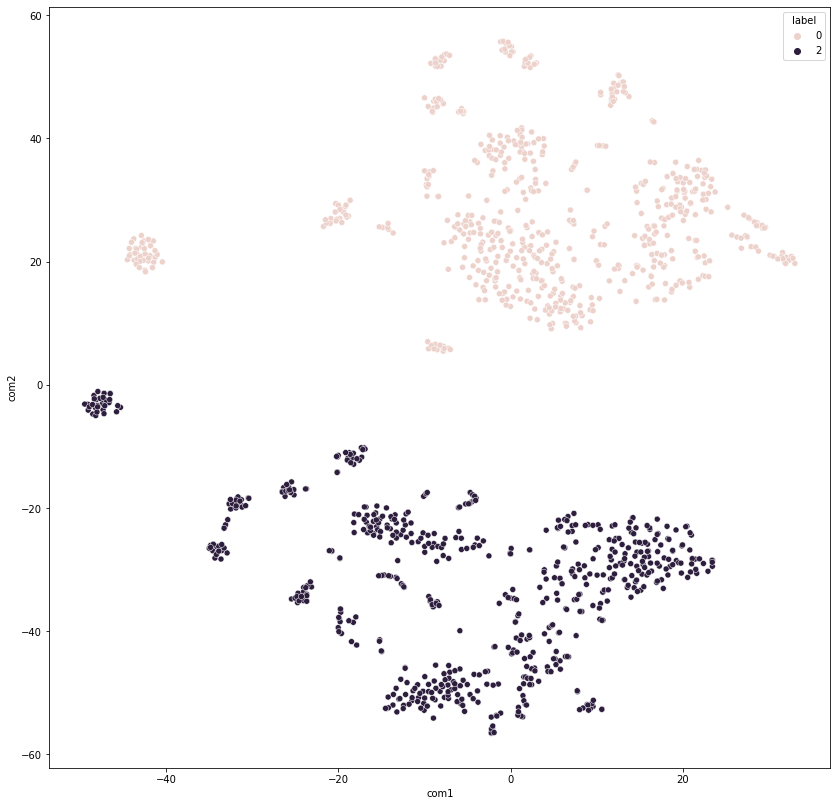

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tt = tsne.fit_transform(X_train)

tt_df = pd.DataFrame(tt, columns=['com1', 'com2'])
tt_df['label'] = train.iloc[:,2]

sns.set_palette('deep')
plt.figure(figsize=(14,14))
sns.scatterplot(x='com1', y='com2', hue='label', data=tt_df)

In [9]:
train_0, train_2 = [], []
for i, fan in enumerate(train.FAN_TYPE):
  if fan == 0:
    train_0.append(X_train[i])
  if fan == 2:
    train_2.append(X_train[i])

test_0, test_2 = [], []    
for i, fan in enumerate(test.FAN_TYPE):
  if fan == 0:
    test_0.append(X_test[i])
  if fan == 2:
    test_2.append(X_test[i])

In [10]:
ss0 = StandardScaler()
train_0 = torch.tensor(ss0.fit_transform(train_0)).float()
test_0 = torch.tensor(ss0.fit_transform(test_0)).float()

ss2 = StandardScaler()
train_2 = torch.tensor(ss2.fit_transform(train_2)).float()
test_2 = torch.tensor(ss2.fit_transform(test_2)).float()

In [11]:
print(len(train_0))
print(len(train_2))
print(len(test_0))
print(len(test_2))

639
640
779
735


---
# 3. Dataset & DataLoader
---

In [12]:
class custom_dataset(Dataset):
  
  def __init__(self, data):

    self.data = data

  def __len__(self):
    return len(self.data)
    

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.data[idx])
    return x


In [13]:
# train
train_0_dataset = custom_dataset(train_0)
train_2_dataset = custom_dataset(train_2)

# test
test_0_dataset = custom_dataset(test_0)
test_2_dataset = custom_dataset(test_2)


# train
train_0_loader = DataLoader(dataset = train_0_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)
train_2_loader = DataLoader(dataset = train_2_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

# test
test_0_loader = DataLoader(dataset = test_0_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)
test_2_loader = DataLoader(dataset = test_2_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

---
# 4. Model
----

In [14]:
class DeepSVDD_network(nn.Module):
    def __init__(self, latent_dim):
        super(DeepSVDD_network, self).__init__()
        self.latent_dim = latent_dim

        self.encoder_layer = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, latent_dim),            
            nn.ReLU(),
              )
        
    def forward(self, x):

        return self.encoder_layer(x)


class pretrain_autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(pretrain_autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder_layer = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),            
            nn.Dropout(0.4),
            nn.Linear(64, latent_dim),
            nn.ReLU(),
        )
        
        self.decoder_layer = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 256),
        )      
    def encoder(self,x):
        return self.encoder_layer(x)

    def decoder(self,x):
        return self.decoder_layer(x)

    def forward(self, x):
        z = self.encoder_layer(x)
        x_hat = self.decoder_layer(z)
        return x_hat

---
# 5. Train
---

In [15]:
class TrainerDeepSVDD:
    def __init__(self, config, data_loader, device, path_dict):
        self.config = config
        self.train_loader = data_loader
        self.device = device
        self.path_dict = path_dict

    def pretrain(self):
        # 가중치 학습 단계
        ae = pretrain_autoencoder(self.config.latent_dim).to(self.device)
        ae.apply(weights_init_normal)
        optimizer = torch.optim.Adam(ae.parameters(), lr=self.config.lr,
                               weight_decay=self.config.weight_decay_ae)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.config.lr_milestones, gamma=0.2)
        
        ae.train()
        for epoch in range(self.config.epoch):
            total_loss = 0
            for x in tqdm(self.train_loader):
                x = x.float().to(self.device)
                
                optimizer.zero_grad()
                x_hat = ae(x)
                
                # scores = (x_hat - x) ** 2
                # reconst_loss = x_hat ** 2 + (1 / 0.1) * torch.mean(torch.max(torch.zeros_like(scores), scores))
                reconst_loss = torch.mean(torch.sum((x_hat - x) ** 2, dim=1))
                reconst_loss.backward()
                optimizer.step()
                
                total_loss += reconst_loss.item()
            scheduler.step()
            print('AutoEncoder /// Epoch: {}, Loss: {:.4f}'.format(epoch, total_loss/len(self.train_loader)))
        self.save_weights_for_DeepSVDD(ae, self.train_loader) 
    

    def save_weights_for_DeepSVDD(self, model, dataloader):
        # 학습된 AutoEncoder 가중치를 DeepSVDD모델에 Initialize
        c = self.set_c(model, dataloader)
        net = DeepSVDD_network(self.config.latent_dim).to(self.device)
        state_dict = model.state_dict()
        net.load_state_dict(state_dict, strict=False)
        torch.save({'center': c.cpu().data.numpy().tolist(),
                    'net_dict': net.state_dict()}, self.path_dict)
    

    def set_c(self, model, dataloader, eps=0.01):
        model.eval()
        z_ = []
        with torch.no_grad():
            for x  in tqdm(dataloader):
                x = x.float().to(self.device)
                z = model.encoder(x)
                z_.append(z.detach())
        z_ = torch.cat(z_)
        c = torch.mean(z_, dim=0)
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c

    def train(self):
        # Deep SVDD model 학습
        net = DeepSVDD_network(self.config.latent_dim).to(self.device)
        
        if self.config.pretrain==True:
            state_dict = torch.load(self.path_dict)
            net.load_state_dict(state_dict['net_dict'])
            c = torch.Tensor(state_dict['center']).to(self.device)
        else:
            net.apply(weights_init_normal)
            c = torch.randn(self.config.latent_dim).to(self.device)
        
        optimizer = torch.optim.Adam(net.parameters(), lr=self.config.lr,
                               weight_decay=self.config.weight_decay)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.config.lr_milestones, gamma=0.2)

        net.train()
        for epoch in range(self.config.epoch):
            total_loss = 0
            for x in tqdm(self.train_loader):
                x = x.float().to(self.device)

                optimizer.zero_grad()
                z = net(x)
                loss = torch.mean(torch.sum((z - c) ** 2, dim=1))
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            scheduler.step()
            print('DeepSVDD /// Epoch: {}, Loss: {:.4f}'.format(epoch, total_loss/len(self.train_loader)))
        self.net = net
        self.c = c

        return self.net, self.c
        
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

In [16]:
fan_0 = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/pretrained_0.pt'
fan_2 = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/pretrained_2.pt'

# Network 학습준비, 구조 불러오기
deep_SVDD_0 = TrainerDeepSVDD(config, train_0_loader, device, fan_0)


# DeepSVDD를 위한 DeepLearning pretrain 모델로 Weight 학습
if config.pretrain:
    deep_SVDD_0.pretrain()

# 학습된 가중치로 Deep_SVDD모델 Train
net_0, c_0 = deep_SVDD_0.train()


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 0, Loss: 258.4721


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 1, Loss: 258.3871


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 2, Loss: 258.2200


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 3, Loss: 258.2895


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 4, Loss: 258.2948


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 5, Loss: 258.2034


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 6, Loss: 258.2270


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 7, Loss: 258.3807


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 8, Loss: 258.2381


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 9, Loss: 258.0847


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 10, Loss: 258.2217


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 11, Loss: 257.9897


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 12, Loss: 258.0772


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 13, Loss: 258.0266


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 14, Loss: 258.0248


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 15, Loss: 257.9236


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 16, Loss: 257.9503


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 17, Loss: 257.9020


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 18, Loss: 257.8684


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 19, Loss: 257.9341


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 20, Loss: 257.8641


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 21, Loss: 257.8958


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 22, Loss: 257.8805


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 23, Loss: 257.8501


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 24, Loss: 257.7155


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 25, Loss: 257.7428


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 26, Loss: 257.7584


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 27, Loss: 257.8897


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 28, Loss: 257.7798


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 29, Loss: 257.8020


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 30, Loss: 257.7124


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 31, Loss: 257.8407


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 32, Loss: 257.7113


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 33, Loss: 257.7107


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 34, Loss: 257.6821


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 35, Loss: 257.7958


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 36, Loss: 257.6308


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 37, Loss: 257.6347


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 38, Loss: 257.6791


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 39, Loss: 257.7684


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 40, Loss: 257.5741


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 41, Loss: 257.7116


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 42, Loss: 257.6903


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 43, Loss: 257.7954


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 44, Loss: 257.5931


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 45, Loss: 257.7378


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 46, Loss: 257.7115


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 47, Loss: 257.7032


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 48, Loss: 257.6632


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 49, Loss: 257.7515


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 50, Loss: 257.7945


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 51, Loss: 257.6064


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 52, Loss: 257.5119


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 53, Loss: 257.6250


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 54, Loss: 257.6968


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 55, Loss: 257.6309


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 56, Loss: 257.6054


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 57, Loss: 257.6754


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 58, Loss: 257.6386


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 59, Loss: 257.6588


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 60, Loss: 257.7615


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 61, Loss: 257.7631


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 62, Loss: 257.6730


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 63, Loss: 257.6553


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 64, Loss: 257.6271


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 65, Loss: 257.6420


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 66, Loss: 257.6346


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 67, Loss: 257.7855


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 68, Loss: 257.6009


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 69, Loss: 257.7147


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 70, Loss: 257.7160


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 71, Loss: 257.4851


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 72, Loss: 257.8774


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 73, Loss: 257.6770


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 74, Loss: 257.5638


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 75, Loss: 257.7172


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 76, Loss: 257.8580


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 77, Loss: 257.5919


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 78, Loss: 257.5244


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 79, Loss: 257.6583


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 80, Loss: 257.5556


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 81, Loss: 257.4953


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 82, Loss: 257.6062


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 83, Loss: 257.5649


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 84, Loss: 257.6532


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 85, Loss: 257.6293


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 86, Loss: 257.6021


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 87, Loss: 257.6590


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 88, Loss: 257.6382


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 89, Loss: 257.5926


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 90, Loss: 257.6566


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 91, Loss: 257.6135


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 92, Loss: 257.6761


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 93, Loss: 257.7697


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 94, Loss: 257.7376


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 95, Loss: 257.6115


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 96, Loss: 257.4953


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 97, Loss: 257.7360


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 98, Loss: 257.6455


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 99, Loss: 257.7391


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 0, Loss: 0.0033


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 1, Loss: 0.0032


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 2, Loss: 0.0029


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 3, Loss: 0.0025


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 4, Loss: 0.0024


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 5, Loss: 0.0023


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 6, Loss: 0.0023


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 7, Loss: 0.0022


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 8, Loss: 0.0019


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 9, Loss: 0.0020


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 10, Loss: 0.0022


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 11, Loss: 0.0021


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 12, Loss: 0.0021


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 13, Loss: 0.0018


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 14, Loss: 0.0016


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 15, Loss: 0.0016


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 16, Loss: 0.0017


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 17, Loss: 0.0016


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 18, Loss: 0.0017


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 19, Loss: 0.0015


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 20, Loss: 0.0015


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 21, Loss: 0.0015


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 22, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 23, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 24, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 25, Loss: 0.0016


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 26, Loss: 0.0015


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 27, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 28, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 29, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 30, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 31, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 32, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 33, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 34, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 35, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 36, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 37, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 38, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 39, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 40, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 41, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 42, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 43, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 44, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 45, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 46, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 47, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 48, Loss: 0.0015


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 49, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 50, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 51, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 52, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 53, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 54, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 55, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 56, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 57, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 58, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 59, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 60, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 61, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 62, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 63, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 64, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 65, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 66, Loss: 0.0011


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 67, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 68, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 69, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 70, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 71, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 72, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 73, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 74, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 75, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 76, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 77, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 78, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 79, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 80, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 81, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 82, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 83, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 84, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 85, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 86, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 87, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 88, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 89, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 90, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 91, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 92, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 93, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 94, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 95, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 96, Loss: 0.0014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 97, Loss: 0.0013


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 98, Loss: 0.0012


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 99, Loss: 0.0013


In [17]:
deep_SVDD_2 = TrainerDeepSVDD(config, train_2_loader, device, fan_2)

if config.pretrain:
    deep_SVDD_2.pretrain()

net_2, c_2 = deep_SVDD_2.train()    

  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 0, Loss: 258.4230


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 1, Loss: 258.5069


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 2, Loss: 258.4390


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 3, Loss: 258.3744


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 4, Loss: 258.4307


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 5, Loss: 258.3242


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 6, Loss: 258.2981


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 7, Loss: 258.3078


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 8, Loss: 258.2633


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 9, Loss: 258.2607


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 10, Loss: 258.3183


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 11, Loss: 258.1569


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 12, Loss: 258.2627


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 13, Loss: 258.1306


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 14, Loss: 258.0667


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 15, Loss: 258.0804


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 16, Loss: 257.9981


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 17, Loss: 258.0353


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 18, Loss: 258.0231


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 19, Loss: 257.9888


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 20, Loss: 257.9853


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 21, Loss: 258.0192


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 22, Loss: 257.8624


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 23, Loss: 257.8520


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 24, Loss: 257.8856


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 25, Loss: 257.7872


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 26, Loss: 257.8882


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 27, Loss: 257.9374


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 28, Loss: 257.9948


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 29, Loss: 257.8848


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 30, Loss: 257.8523


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 31, Loss: 257.8520


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 32, Loss: 257.8590


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 33, Loss: 257.8384


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 34, Loss: 257.8778


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 35, Loss: 257.8721


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 36, Loss: 257.8139


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 37, Loss: 257.8728


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 38, Loss: 257.7824


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 39, Loss: 257.7554


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 40, Loss: 257.8091


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 41, Loss: 257.8249


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 42, Loss: 257.7297


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 43, Loss: 257.8606


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 44, Loss: 257.8798


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 45, Loss: 257.7782


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 46, Loss: 257.8789


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 47, Loss: 257.7797


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 48, Loss: 257.8704


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 49, Loss: 257.7402


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 50, Loss: 257.7886


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 51, Loss: 257.7571


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 52, Loss: 257.8234


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 53, Loss: 257.8248


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 54, Loss: 257.8151


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 55, Loss: 257.7292


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 56, Loss: 257.7989


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 57, Loss: 257.8421


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 58, Loss: 257.8745


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 59, Loss: 257.7955


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 60, Loss: 257.8050


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 61, Loss: 257.7517


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 62, Loss: 257.7466


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 63, Loss: 257.7932


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 64, Loss: 257.8205


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 65, Loss: 257.7776


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 66, Loss: 257.7350


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 67, Loss: 257.8452


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 68, Loss: 257.7374


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 69, Loss: 257.7364


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 70, Loss: 257.7854


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 71, Loss: 257.6997


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 72, Loss: 257.7331


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 73, Loss: 257.7613


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 74, Loss: 257.8077


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 75, Loss: 257.7680


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 76, Loss: 257.8257


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 77, Loss: 257.8059


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 78, Loss: 257.8287


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 79, Loss: 257.6806


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 80, Loss: 257.7183


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 81, Loss: 257.7420


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 82, Loss: 257.7967


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 83, Loss: 257.6408


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 84, Loss: 257.7687


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 85, Loss: 257.8202


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 86, Loss: 257.7365


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 87, Loss: 257.7202


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 88, Loss: 257.7805


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 89, Loss: 257.7008


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 90, Loss: 257.7287


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 91, Loss: 257.8502


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 92, Loss: 257.7633


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 93, Loss: 257.7074


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 94, Loss: 257.7680


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 95, Loss: 257.7437


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 96, Loss: 257.7140


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 97, Loss: 257.7107


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 98, Loss: 257.5535


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 99, Loss: 257.8118


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 0, Loss: 0.0375


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 1, Loss: 0.0357


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 2, Loss: 0.0329


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 3, Loss: 0.0328


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 4, Loss: 0.0278


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 5, Loss: 0.0286


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 6, Loss: 0.0252


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 7, Loss: 0.0242


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 8, Loss: 0.0230


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 9, Loss: 0.0209


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 10, Loss: 0.0202


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 11, Loss: 0.0206


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 12, Loss: 0.0177


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 13, Loss: 0.0156


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 14, Loss: 0.0153


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 15, Loss: 0.0155


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 16, Loss: 0.0135


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 17, Loss: 0.0134


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 18, Loss: 0.0127


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 19, Loss: 0.0129


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 20, Loss: 0.0114


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 21, Loss: 0.0107


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 22, Loss: 0.0094


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 23, Loss: 0.0083


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 24, Loss: 0.0085


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 25, Loss: 0.0076


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 26, Loss: 0.0078


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 27, Loss: 0.0081


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 28, Loss: 0.0085


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 29, Loss: 0.0076


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 30, Loss: 0.0088


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 31, Loss: 0.0074


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 32, Loss: 0.0073


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 33, Loss: 0.0074


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 34, Loss: 0.0073


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 35, Loss: 0.0074


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 36, Loss: 0.0068


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 37, Loss: 0.0066


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 38, Loss: 0.0073


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 39, Loss: 0.0068


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 40, Loss: 0.0074


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 41, Loss: 0.0071


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 42, Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 43, Loss: 0.0066


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 44, Loss: 0.0064


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 45, Loss: 0.0067


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 46, Loss: 0.0064


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 47, Loss: 0.0063


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 48, Loss: 0.0063


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 49, Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 50, Loss: 0.0062


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 51, Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 52, Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 53, Loss: 0.0065


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 54, Loss: 0.0064


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 55, Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 56, Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 57, Loss: 0.0066


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 58, Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 59, Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 60, Loss: 0.0057


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 61, Loss: 0.0064


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 62, Loss: 0.0054


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 63, Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 64, Loss: 0.0063


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 65, Loss: 0.0062


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 66, Loss: 0.0057


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 67, Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 68, Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 69, Loss: 0.0054


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 70, Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 71, Loss: 0.0062


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 72, Loss: 0.0056


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 73, Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 74, Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 75, Loss: 0.0062


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 76, Loss: 0.0056


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 77, Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 78, Loss: 0.0066


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 79, Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 80, Loss: 0.0055


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 81, Loss: 0.0052


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 82, Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 83, Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 84, Loss: 0.0064


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 85, Loss: 0.0054


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 86, Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 87, Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 88, Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 89, Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 90, Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 91, Loss: 0.0055


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 92, Loss: 0.0064


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 93, Loss: 0.0055


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 94, Loss: 0.0062


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 95, Loss: 0.0055


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 96, Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 97, Loss: 0.0060


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 98, Loss: 0.0055


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 99, Loss: 0.0066


---
# 6. Prediction
----

In [18]:
def eval(net, c, dataloader, device):
  scores = []
  net.eval()
  with torch.no_grad():
    for x in dataloader:
      x = x.float().to(device)
      z = net(x)
      score = torch.sum((z - c) ** 2, dim=1)
      scores.append(score.detach().cpu())
  scores = torch.cat(scores).numpy()
  return scores

In [19]:
train_0_score = eval(net_0 ,c_0 ,train_0_loader, device)
train_2_score = eval(net_2 ,c_2 ,train_2_loader, device)

In [20]:
test_0_score = eval(net_0 ,c_0 ,test_0_loader, device)
test_2_score = eval(net_2 ,c_2 ,test_2_loader, device)

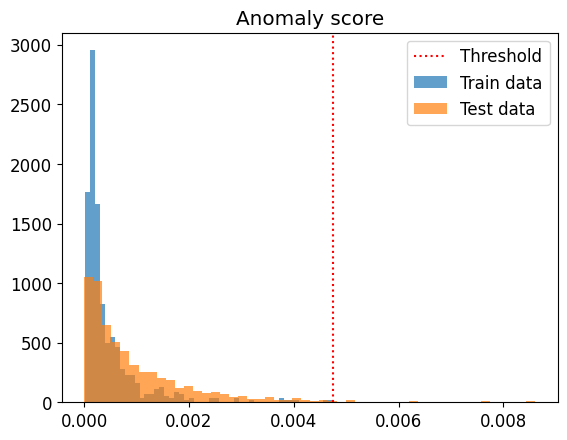

In [21]:
t_hold_0 = np.sort(np.array(train_0_score))[::-1]


for i, data in enumerate(t_hold_0):
    if(t_hold_0[i] - t_hold_0[i+1] < 0.01):
        Threshold_0 = data
        break

plt.style.use('default')
plt.rcParams['font.size'] = 12

plt.hist(train_0_score, bins=50, density=True, alpha=0.7, label='Train data')
plt.hist(test_0_score, bins=50, density=True, alpha=0.7, label='Test data')
plt.axvline(x=Threshold_0, c='red', linestyle=':', label='Threshold')

plt.title("Anomaly score")
plt.legend()

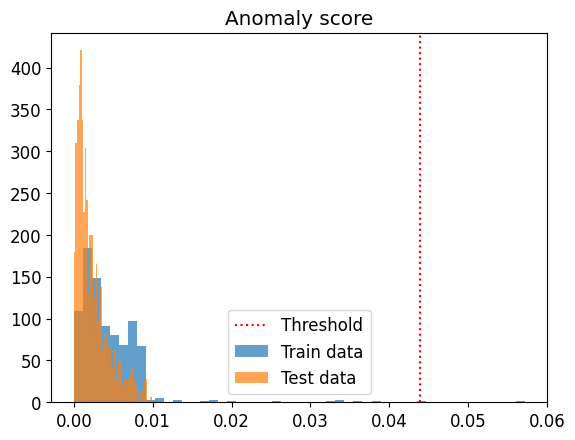

In [22]:
t_hold_2 = np.sort(np.array(train_2_score))[::-1]

for i, data in enumerate(t_hold_2):
    if(t_hold_2[i] - t_hold_2[i+1] < 0.01):
        Threshold_2 = data
        break

plt.style.use('default')
plt.rcParams['font.size'] = 12

plt.hist(train_2_score, bins=50, density=True, alpha=0.7, label='Train data')
plt.hist(test_2_score, bins=50, density=True, alpha=0.7, label='Test data')
plt.axvline(x=Threshold_2, c='red', linestyle=':', label='Threshold')

plt.title("Anomaly score")
plt.legend()

In [23]:
test_0 = np.zeros(len(test_0_score))
test_2 = np.zeros(len(test_2_score))

for i, value in enumerate(test_0_score):
    if value < Threshold_0:
        test_0[i] = 0
    else:
        test_0[i] = 1

for i, value in enumerate(test_2_score):
    if value < Threshold_2 :
        test_2[i] = 0
    else:
        test_2[i] = 1



In [24]:
n0 = -1
n2 = -1
Test_Result = []

for i, fan in enumerate(test.FAN_TYPE):
  if fan == 0:
      n0 += 1
      Test_Result.append(test_0[n0])
      
  if fan == 2:
      n2 += 1
      Test_Result.append(test_2[n2])

In [25]:
Counter(Test_Result)

Counter({0.0: 1509, 1.0: 5})

---
# 7. Submisson
---

In [26]:
df = pd.DataFrame(np.array(Test_Result))

sub = pd.read_csv(config.sub)
sub['LABEL'] = df.astype(int)
sub

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
1509,TEST_1509,0
1510,TEST_1510,0
1511,TEST_1511,0
1512,TEST_1512,0


In [27]:
sub.to_csv('/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sub_0201_DeepSVDD.csv', index = False)